# Text Classifcation using DistilBERT (a demo based on Rotten Tomatoes)

In [ ]:
!pip install datasets

In [2]:
import os
import random
import torch
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score
from datasets import load_dataset

from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

## Load dataset

In [6]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

## Load DistilBERT and Fine-Tuning

In [3]:
# set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
device = "cuda" ## change it to your GPU device type
model_id = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply the tokenizer to the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [8]:
# Start fine-tuning
trainer = Trainer(model=model.to(device),
          args=TrainingArguments(output_dir="./results",
                      learning_rate=2e-5,
                      per_device_train_batch_size=16,
                      per_device_eval_batch_size=16,
                      weight_decay=0.01,
                      logging_steps=50,
                      num_train_epochs=5,
                      save_strategy="steps",
                      eval_strategy="steps",  # Evaluate after a certain number of steps
                      load_best_model_at_end=True,
                      report_to='none',
                      seed=0),
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          callbacks=[EarlyStoppingCallback(early_stopping_patience=1)])
trainer.train()

Step,Training Loss,Validation Loss
50,0.668600,0.549151
100,0.482000,0.437705
150,0.470800,0.459449
200,0.414100,0.390876
250,0.393500,0.386605
300,0.404300,0.395635
350,0.373800,0.463930
400,0.365700,0.407686
450,0.394600,0.359516
500,0.345300,0.357756


TrainOutput(global_step=550, training_loss=0.4203940894386985, metrics={'train_runtime': 627.7687, 'train_samples_per_second': 67.939, 'train_steps_per_second': 4.253, 'total_flos': 1163858564591616.0, 'train_loss': 0.4203940894386985, 'epoch': 1.0299625468164795})

In [10]:
# save tuned model
save_path="./distilbert-rotten-tuned"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('./distilbert-rotten-tuned/tokenizer_config.json',
 './distilbert-rotten-tuned/special_tokens_map.json',
 './distilbert-rotten-tuned/vocab.txt',
 './distilbert-rotten-tuned/added_tokens.json',
 './distilbert-rotten-tuned/tokenizer.json')

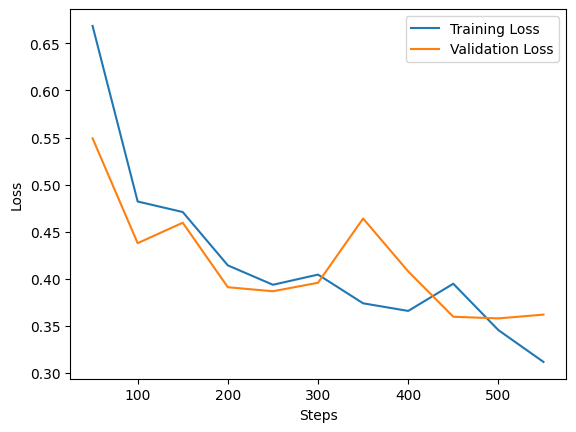

In [11]:
# Visualize losses
log_train = {}
for i in range(int(len(trainer.state.log_history[:-1]) / 2)):
    step = trainer.state.log_history[2 * i]["step"]
    train_loss = trainer.state.log_history[2 * i]["loss"]
    eval_loss = trainer.state.log_history[2 * i + 1]["eval_loss"]
    log_train[step] = {"Training Loss": train_loss,
                       "Validation Loss": eval_loss}
pd.DataFrame(log_train).T.plot(ylabel="Loss", xlabel="Steps")
plt.show()

## Compare raw DistilBERT and Finetuned models

In [12]:
# Raw DistilBERT model
model_id = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, output_hidden_states=True).to(device)

for split in dataset.keys():
    if "embedding" in dataset[split].column_names:
        dataset[split] = dataset[split].remove_columns("embedding")
        continue

    word_embeddings_all = []
    with torch.no_grad():
        for sentence in dataset[split]["text"]:
            encoding = tokenizer.encode_plus(sentence,  # List of input texts
                                 # padding=True,              # Pad to the maximum sequence length
                                 truncation=True,  # Truncate to the maximum sequence length if necessary
                                 return_tensors='pt',  # Return PyTorch tensors
                                 add_special_tokens=True  # Add special tokens CLS and SEP
                               )
            outputs = model(encoding['input_ids'].to(device))
            word_embeddings = torch.mean(outputs['hidden_states'][-1], dim=1).cpu().numpy()[0]
            word_embeddings_all.append(word_embeddings)

    dataset[split] = dataset[split].add_column("embedding", word_embeddings_all)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Finetuned Model

model_id = "./distilbert-rotten-tuned"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, output_hidden_states=True).to(device)

for split in dataset.keys():
    if "embedding-tune" in dataset[split].column_names:
        dataset[split] = dataset[split].remove_columns("embedding-tune")
        continue

    word_embeddings_all = []
    with torch.no_grad():
        for sentence in dataset[split]["text"]:
            encoding = tokenizer.encode_plus(sentence,  # List of input texts
                                 # padding=True,              # Pad to the maximum sequence length
                                 truncation=True,  # Truncate to the maximum sequence length if necessary
                                 return_tensors='pt',  # Return PyTorch tensors
                                 add_special_tokens=True  # Add special tokens CLS and SEP
                               )
            outputs = model(encoding['input_ids'].to(device))
            word_embeddings = torch.mean(outputs['hidden_states'][-1], dim=1).cpu().numpy()[0]
            word_embeddings_all.append(word_embeddings)

    dataset[split] = dataset[split].add_column("embedding-tune", word_embeddings_all)

## Evaluate Performance

In [14]:
def evaluate_embedding(dataset, embedding_col):

    ## prepare X, y data for linear model fitting
    y_train = dataset["train"]["label"]
    y_validation = dataset["validation"]["label"]
    y_test = dataset["test"]["label"]

    embedding_train = np.array(dataset["train"][embedding_col])
    embedding_validation = np.array(dataset["validation"][embedding_col])
    embedding_test = np.array(dataset["test"][embedding_col])

    ## fit Logistic regression model
    lr = LogisticRegression(max_iter=1000, fit_intercept=True)
    lr.fit(embedding_train, y_train)

    pred_proba_train = lr.predict_proba(embedding_train)[:,1]
    pred_proba_test = lr.predict_proba(embedding_test)[:,1]

    train_auc = roc_auc_score(y_train, pred_proba_train)
    test_auc = roc_auc_score(y_test, pred_proba_test)
    return train_auc, test_auc

In [15]:
results = {}
for embedding_col in ["embedding", "embedding-tune"]:
    train_auc, test_auc = evaluate_embedding(dataset, embedding_col=embedding_col)
    results[embedding_col] = {"train_auc": train_auc,
                              "test_auc": test_auc}

In [19]:
pd.DataFrame({"DistilBERT-raw": {"train-AUC": results["embedding"]["train_auc"], "test-AUC":results["embedding"]["test_auc"]},
              "DistilBERT-finetuned": {"train-AUC": results["embedding-tune"]["train_auc"], "test-AUC":results["embedding-tune"]["test_auc"]}
              })

,DistilBERT-raw,DistilBERT-finetuned
train-AUC,0.918097,0.980089
test-AUC,0.882378,0.911010
